## iPyLeaflet
[ipyleaflet](https://github.com/ellisonbg/ipyleaflet) is a bridge between jupyter notebooks and the [leaflet](http://leafletjs.com/)  javascript library for drawing maps.

ipyleaflet comes with a few examples notebooks (this notebook was derived from one) but very little documentation,
for more documentation read the [Leaflet IPA](http://leafletjs.com/reference.html)

For installation directions, see the README on [ipyleaflet](https://github.com/ellisonbg/ipyleaflet)

In [1]:

from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl
)

## Visualizing the distribution of the observations

## Load the required libraries

In [2]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math

In [3]:
import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

In [4]:
import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from computeStats import computeOverAllDist, STAT_Descriptions

In [5]:
### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index= 'SSSBSBBS'#'BBBSBBBB'
meas='SNWD'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print('keys from STAT=',STAT.keys())

#!ls -ld $data_dir/*.parquet

#read data
filename=data_dir+'/decon_%s_%s.parquet'%(file_index,meas)

df=sqlContext.read.parquet(filename)
print(df.count())
df.show(2)

('keys from STAT=', ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP'])
330
+-----------------+-------------------+-------------------+---------+--------+--------+---------+-----------+-------------------+-------------------+-------------------+------------------+-----------+------------+------+--------------------+------+
|          coeff_1|            coeff_2|            coeff_3|elevation|   label|latitude|longitude|measurement|              res_1|              res_2|              res_3|          res_mean|    station|   total_var|undefs|              vector|  year|
+-----------------+-------------------+-------------------+---------+--------+--------+---------+-----------+-------------------+-------------------+-------------------+------------------+-----------+------------+------+--------------------+------+
|5023.264685707682| 1366.1120680592157|-1450.7536366819654|   2235.4|SSSBSBBS| 38.9783|-119.8914|       SNWD|0.24744997302435828|0.22476502263087728| 0.1838983630669596|0.85622048

In [30]:
#extract longitude and latitude for each station
feature='coeff_1'
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT station, latitude,longitude,elevation,%s FROM weather"%feature
print(Query)
df1 = sqlContext.sql(Query)
df1.show(4)

SELECT station, latitude,longitude,elevation,coeff_1 FROM weather
+-----------+--------+---------+---------+------------------+
|    station|latitude|longitude|elevation|           coeff_1|
+-----------+--------+---------+---------+------------------+
|USC00262119| 38.9783|-119.8914|   2235.4| 5023.264685707682|
|USC00042671| 38.7833|-120.0333|   2240.3| 8700.867038390956|
|USC00045571| 38.8167|-120.0167|   1973.0| 7090.321891651193|
|USC00049105| 38.7086|-120.0403|   2438.4|10077.856645005568|
+-----------+--------+---------+---------+------------------+
only showing top 4 rows



In [37]:
max_long_query= "SELECT station, longitude FROM weather ORDER BY longitude desc"
df6 = sqlContext.sql(max_long_query)
df6.show(1)

min_long_query= "SELECT station, longitude FROM weather ORDER BY longitude asc"
df3 = sqlContext.sql(min_long_query)
df3.show(1)

max_lat_query= "SELECT station, latitude FROM weather ORDER BY latitude desc"
df4 = sqlContext.sql(max_lat_query)
df4.show(1)

min_long_query= "SELECT station, latitude FROM weather ORDER BY latitude asc"
df5 = sqlContext.sql(min_long_query)
df5.show(1)



+-----------+---------+
|    station|longitude|
+-----------+---------+
|USC00260955|-115.5444|
+-----------+---------+
only showing top 1 row

+-----------+---------+
|    station|longitude|
+-----------+---------+
|USC00043134| -120.845|
+-----------+---------+
only showing top 1 row

+-----------+--------+
|    station|latitude|
+-----------+--------+
|USC00263205| 39.0753|
+-----------+--------+
only showing top 1 row

+-----------+--------+
|    station|latitude|
+-----------+--------+
|USC00040943| 38.2119|
+-----------+--------+
only showing top 1 row



In [53]:
df2=df1.groupby(['station','latitude','longitude','elevation']).agg({"station": "count", feature: "mean"})
pdf=df2.toPandas()
pdf.sort_values(by=['station'],inplace=True)
pdf.head(2)

,station,latitude,longitude,elevation,count(station),avg(coeff_1)
28,USC00040943,38.2119,-119.0142,2551.2,39,3995.787717
20,USC00041072,38.2575,-119.2286,1972.1,29,506.622594


In [39]:
#define a mapping from the range of the value to hex colors.
from matplotlib.colors import rgb2hex
_avg='avg(%s)'%feature
_min=pdf[_avg].min()
_max=pdf[_avg].max()
_min,_max

import pylab as plt
cmap=plt.get_cmap('jet')
def get_color(val):
    x=(val-_min)/(_max-_min)
    return(rgb2hex(cmap(x)[:3]))

get_color(1000.)

u'#0008ff'

## Map

In [40]:
min_lat,max_lat,min_long,max_long = box = ( 38.2119 ,39.0753, -120.845, -115.5444 )#(42.1103, 42.6167, -72.6, -70.8)


In [41]:
# fix using: jupyter nbextension enable --py --sys-prefix ipyleaflet 
center = [(min_lat+max_lat)/2, (min_long+max_long)/2]
zoom = 9

m = Map(default_tiles=TileLayer(opacity=1.0), center=center, zoom=zoom)

r = Rectangle(bounds=[[min_lat,min_long],[max_lat,max_long]], weight=5, fill_opacity=0.0)
m += r

lat_margin=(max_lat-min_lat)/4
long_margin=(max_long-min_long)/4
circles = []
for index,row in pdf.iterrows():
    _lat=row['latitude']
    _long=row['longitude']
    _count=row['count(station)']
    _coef=row[_avg]
    # taking sqrt of count so that the  area of the circle corresponds to the count
    c = Circle(location=(_lat,_long), radius=int(300*np.sqrt(_count+0.0)), weight=1,
            color='#F00', opacity=0.8, fill_opacity=0.4,
            fill_color=get_color(_coef))
    circles.append(c)
    m.add_layer(c)
m    

In [85]:
# fix using: jupyter nbextension enable --py --sys-prefix ipyleaflet 
center = [(min_lat+max_lat)/2, (min_long+max_long)/2]
zoom = 9

m = Map(default_tiles=TileLayer(opacity=1.0), center=center, zoom=zoom)

r = Rectangle(bounds=[[min_lat,min_long],[max_lat,max_long]], weight=5, fill_opacity=0.0)
m += r

lat_margin=(max_lat-min_lat)/4
long_margin=(max_long-min_long)/4
circles = []
corr_stations = [u'USC00043381',u'USC00043384',u'USC00268186',u'USC00041909']#, u'USC00045356',u'USC00048928']
# coeff_1 long [u'USC00045356', u'USC00049582', u'USC00260955', u'USC00263205', u'USC00048760', u'USC00043381' ,u'USC00048928',u'USC00041909', u'USC00268186', u'USC00268202', u'USC00045571', u'USC00043384', u'USC00041911', u'USC00041277']
# coeff_2[u'USC00260955', u'USC00049582', u'USC00266746', u'USC00267640']
# coeff 1[u'USC00041909', u'USC00268186', u'USC00268202', u'USC00045571', u'USC00043384', u'USC00041911', u'USC00041277']#[u'USC00049582', u'USC00260955', u'USC00267640']
#[u'USC00041909', u'USC00268186']
for index,row in pdf.iterrows():
    if row['station'] in corr_stations:
        _lat=row['latitude']
        _long=row['longitude']
        _count=row['count(station)']
        _coef=row[_avg]
        print "station: ",row['station'],",elevation: ",row['elevation']#, ",Longitude: ", _long,",Latitude: ",_lat
        # taking sqrt of count so that the  area of the circle corresponds to the count
        c = Circle(location=(_lat,_long), radius=int(300*np.sqrt(25+0.0)), weight=1,
                color='#F00', opacity=0.8, fill_opacity=0.4,
                fill_color=get_color(_coef))
        circles.append(c)
        m.add_layer(c)
m    

station:  USC00041909 ,elevation:  1556.0
station:  USC00043381 ,elevation:  830.0
station:  USC00043384 ,elevation:  914.7
station:  USC00268186 ,elevation:  1544.7


### excercises:
* Add a legend that relates the colors to values.
* Leaflet supports a variety of maps. See if you can get a topographical map as the background.

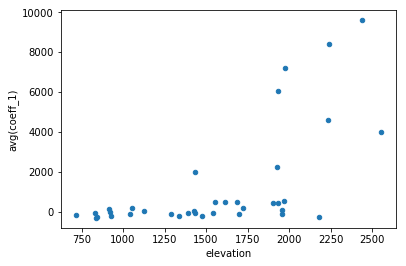

In [11]:
%matplotlib inline
pdf.plot.scatter(x='elevation',y='avg(coeff_1)');

In [12]:
RDD1=sc.parallelize(["spark  basics", "spark big  data analysis", "spring"]) 
RDD2=sc.parallelize(["spark using pyspark", "big data"])
 
RDD1.subtract(RDD2).collect()

['spark big  data analysis', 'spring', 'spark  basics']